# Solving the Max-Cut problem

In this notebook, we describe how to solve the Max-Cut problem with LunaSolve. We will begin by defining, explaining, and giving an example of the Max-Cut problem. We will then continue by modeling a problem instance before optimizing and implementing the solution using LunaSolve. Finally, we will also take a closer look at the interpretation of the answer returned from Luna.

## Table of Contents

1. [Introduction](#1)
2. [Real World Example](#2)
3. [Solving the Max-Cut Problem with Luna](#3)



<a id="1"></a>
## 1. Introduction

### Max-Cut
The Max-Cut problem is a classical challenge in combinatorial optimization and graph theory. Given a graph $ G $ that represents some complex system, the goal of the Max-Cut problem is to find a partition of the graph’s nodes into two complementary sets $ A $ and $ B $ such that the number of edges between $ A $ and $ B $ is as large as possible.

We can define this problem also in a more formal manner. Let $G = (V, E)$ be an undirected graph. A *cut* is defined by partitioning the vertex set $V$ into two disjoint subsets $A$ and $B$. The size (or weight) of this cut is the number of edges that connect a vertex in $A$ to a vertex in $B$. The **Max-Cut** problem asks to find such a partition $(A, B)$ that maximizes the number of edges running between $A$ and $B$.

Though this may sound like mathematical jargon, the essential question is: how can we split a collection of points into two subgroups so that the number of connections linking the two subgroups is maximized?




<a id="2"></a>
## 2. Real World Example

A helpful way to understand the problem is by considering its application in everyday life. For instance, imagine a company wants to distribute promotional samples to a group of people in a way that maximizes word-of-mouth exposure. Each person is represented as a node in a graph, and an edge exists between two nodes if those people are friends.

If two people are friends, they are more likely to communicate and discuss news—where the product might also be mentioned. To maximize the exposure gained by these free samples through word-of-mouth communication, the company’s goal is to split the group into two sets—Group A and Group B—such that the number of friendships (edges) connecting individuals across the two groups is as large as possible. Then, the free samples can be given to one (for instance, the smaller) group in order to encourage more cross-group conversations about the product, while not giving out too many free samples.


<a id="3"></a>
## 3. Solving the Max-Cut problem with Luna

To follow along with the next steps, three libraries are needed:
1. **luna-quantum** for encoding and solving our optimization problem,  
2. **matplotlib** for visualization, and  
3. **networkx** for creating and drawing the graph.  

The cell below installs these packages for you if they are not already installed.

In [1]:
# Install dependencies
%pip install --upgrade pip
%pip install luna-quantum --upgrade
%pip install matplotlib networkx

Note: you may need to restart the kernel to use updated packages.
Note: you may need to restart the kernel to use updated packages.
Note: you may need to restart the kernel to use updated packages.


### 3.1 Setup Luna Client

Now, let's walk through the implementation of the Max-Cut problem using LunaSolve. First, create an encryption key. You can generate a key [here](https://docs.aqarios.com/get-started#luna-encryption).


In [2]:
import os
os.environ["LUNA_ENCRYPTION_KEY"] = "gzaUL8hDECWXRcGrJiEa5wVWVgt4sgPbBDjKN8I92ps="

As the next step, instantiate a LunaSolve object and set your credentials. The API key is needed to identify you and grant access to the Luna platform. You can find it in your Aqarios account settings.

In [3]:
from luna_sdk import LunaSolve
ls = LunaSolve(api_key="60360df4e8b54305aababfa6ac99429e")

### 3.2 Create a Max-Cut problem

To create a Max-Cut instance, any graph with vertices and edges is sufficient. In this notebook, we will create one representing the network of friendships among 9 people, labeled from 0 to 8. Some pairs of these people are friends, and we express this relationship through edges in the graph. After defining the graph, we will visualize it for better comprehension.

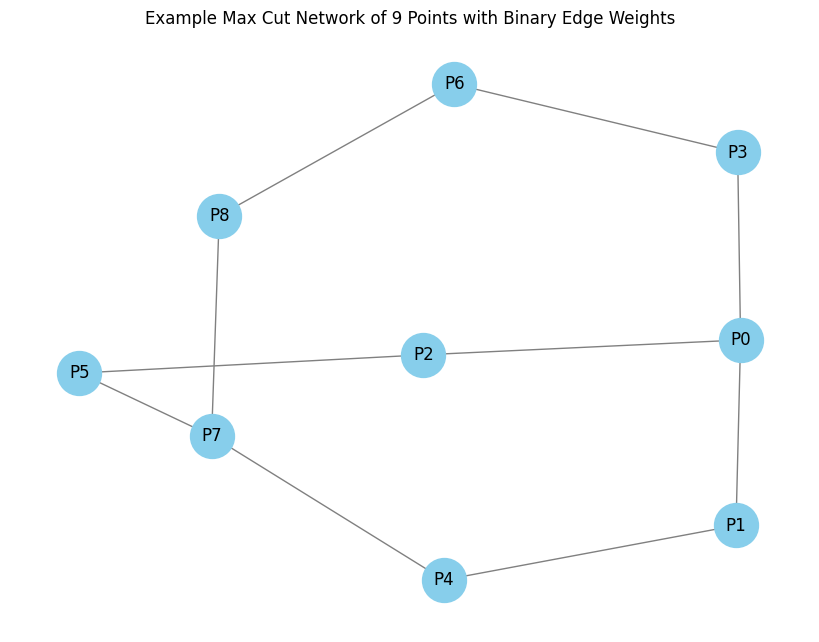

In [4]:
import networkx as nx
import matplotlib.pyplot as plt

max_cut_graph = nx.Graph()

# Add people (nodes)
nodes = ["P0", "P1", "P2", "P3", "P4", "P5", "P6", "P7", "P8"]
max_cut_graph.add_nodes_from(nodes)

# Define edges (friendships) 
edges = [
    ("P0", "P1"), ("P0", "P2"), ("P0", "P3"),
    ("P1", "P4"), ("P2", "P5"), ("P3", "P6"),
    ("P4", "P7"), ("P5", "P7"), ("P6", "P8"),
    ("P7", "P8")
]
max_cut_graph.add_edges_from(edges)

max_cut_graph_str = nx.relabel_nodes(max_cut_graph, lambda x: str(x))
graph_dict = nx.to_dict_of_dicts(max_cut_graph_str)


# Draw the graph
plt.figure(figsize=(8, 6))
pos = nx.spring_layout(max_cut_graph)  
nx.draw(max_cut_graph, pos, with_labels=True, node_color="skyblue", edge_color="gray", node_size=1000, font_size=12)
plt.title("Example Max Cut Network of 9 Points with Binary Edge Weights")
plt.show()

### 3.3 Creating a Max-Cut Object

The graph we created now represents a friendship network. To find the optimal partition using LunaSolve, we define the Max-Cut use case using Luna’s `MaxCut` class. This class converts the friendship network graph into a QUBO optimization problem, which Luna can then optimize.

In [5]:
# import the MaxCut object from the luna_sdk
from luna_sdk.schemas import MaxCut

# create a MaxCut object
max_cut = MaxCut(graph=graph_dict)

### 3.4 Create Luna Optimization

We can now upload the problem instance to Luna as an optimization and solve it afterward.

In [6]:
optimization = ls.optimization.create_from_use_case(name="Max-Cut Sample Distribution", use_case=max_cut)

### 3.5 Create a Luna Solution

The next step involves creating a job, which is an outbound request to the hardware provider to solve the optimisation problem. By calling the `ls.solution.create()` method of LunaSolve we can create the outbound job. This method takes care of optimizing our problem. To solve the Max Independent Set problem, we pass the `optimization_id` from our optimisation object of our use case, specify the `solver_name` we choose, the `provider` of the computing hardware, `solver_parameters` (which may be specific to the solver), and a `qpu_token` if needed.

In this instance, we solve the Max Independent Set problem using simulated annealing (sa) and choose D-Wave (dwave) as the hardware provider.

In [7]:
job = ls.solution.create(
    optimization_id=optimization.id,
    solver_name="sa",
    provider="dwave",
    solver_parameters={}
)

### 3.6 Retrieve the Solution

In step 3.4, we uploaded the problem, and in 3.5, we made a solve request to Luna. Luna sends the optimisation problem to the provider specified and is returned a solution. Luna autonomously takes care of all background activities, during which the user can turn to other of their important matters. The background processes include the creation and translation of the optimisation problem for the according hardware provider, sending out the request and obtaining a result back, and translating the solution back to an interpretable format.

The `Solution` object created, has multiple attributes expressing different factors of the optimisation problem. These include meta data of the optimisation and the sampled results. The optimisation meta data includes information attached to the use case problem, such as `id`, `name`, `solver`and `provider` names, `runtime` and `qpu` type. Lastly, the `status` variable indicates if the job has been successfully executed and returned to Luna. If the status variable says DONE, the optimisation has finished. In the case REQUESTED is displayed for the status, your optimisation is still being processed. Wait a little bit and re-execute the cell, to retrieve the updated solution.

In [8]:
solution = ls.solution.get(solution_id=job.id)
print(solution)

id: 67b44524acb6eea462be3a48
name: Max-Cut Sample Distribution
status: DONE
solver: SA
provider: dwave
runtime:
    total: 0.008472229936160147
    qpu: None
optimization_name: QUBO_MATRIX
created_date: 2025-02-18 08:30:28 (+07)
results:
1 results found. Displaying first 5 results.
Result 1:
    {'sample': {'x0': 0.0, 'x1': 1.0, 'x2': 1.0, 'x3': 1.0, 'x4': 0.0, 'x5': 0.0, 'x6': 1.0, 'x7': 1.0, 'x8': 0.0}, 'obj_value': -9.0, 'feasible': True, '   ....

sense: min
results: [{'representation': [['P0', 'P4', 'P5', 'P8'], ['P1', 'P2', 'P3', 'P6', 'P7']], 'obj_value': -9.0}]
description: Two sets of nodes representing the cut as Tuple of lists.

representation=[['P0', 'P4', 'P5', 'P8'], ['P1', 'P2', 'P3', 'P6', 'P7']] obj_value=-9.0


Because we converted the use case into the QUBO format, the solution we are returned from our provider is also in this format, which typically is in a vectorised form. However, the encoding from our original optimisation problem might be different. Slack variables, linearisations and transformations between optimisation formats can alter the variable description of optimisation methods. As aforementioned, Luna performs a post-processing step which transforms the solution from the QUBO domain back to a more intuitive domain. 

The `ls.solution.get_use_case_representation(solution_id=job.id)` method transforms the solution of our optimisation to a readable format. The `sense`attribute informs us if we are trying to maximize or minimize our objective function. The `result` is typically given as an iterable containing the `representation` which contains the solution, and the `òbj_value`. The objective value is difficult to interpret as it encompasses both optimization values and constraint penalties, however smaller values express better solutions. The `description` explains the encoding of the `representation` of the result. 

The formal definition of the Max-Cut problem, the variables $x_i$ encode the values given to the nodes of the graph as they are also encoded in the `nx.to_dict_of_dicts(max_cut_graph)` dictionary. If the value is equal to zero, it means that the node (person) has been selected to be part of one partition of the graph, while one means that the node (person) is part of the other partition. 

Accordingly, in the case of the Max-Cut problem, the representation is a tuple a lists. Each list contains the indices of all nodes that are included in the two partitions according to the selected cut. In other words, the representation is a set of two list. One containing all indices $i$, for which their decision variable $x_i$ is equal to one. And the other containing all indices $i$, for which their decision variable $x_i$ is equal to zero.

In [ ]:
use_case_repr = ls.solution.get_use_case_representation(job.id)
print(use_case_repr)

Finally, if we wish to see the best solution from all evaluated samples we can call the `ls.solution.get_best_use_case_result(use_case_representation=use_case_repr)` method.

In [ ]:
best_solution = ls.solution.get_best_use_case_result(use_case_repr)

print(best_solution)

If you create multiple results in one solve job, you can also retrieve the best result:

In [9]:
partition_dict = {}

colour = "green"
for cut in best_solution.representation:
    partition_dict.update({node : colour for node in cut})
    colour = "red"
print(partition_dict)
colours = [partition_dict[node] for node in max_cut_graph.nodes()]
print(colours)


{'P0': 'green', 'P4': 'green', 'P5': 'green', 'P8': 'green', 'P1': 'red', 'P2': 'red', 'P3': 'red', 'P6': 'red', 'P7': 'red'}
['green', 'red', 'red', 'red', 'green', 'green', 'red', 'red', 'green']


In order to better grasp the solution, we can visualize again our friendship connections using the graph we created, and colour all nodes which have a value of 0 red and all others that are 1, green.

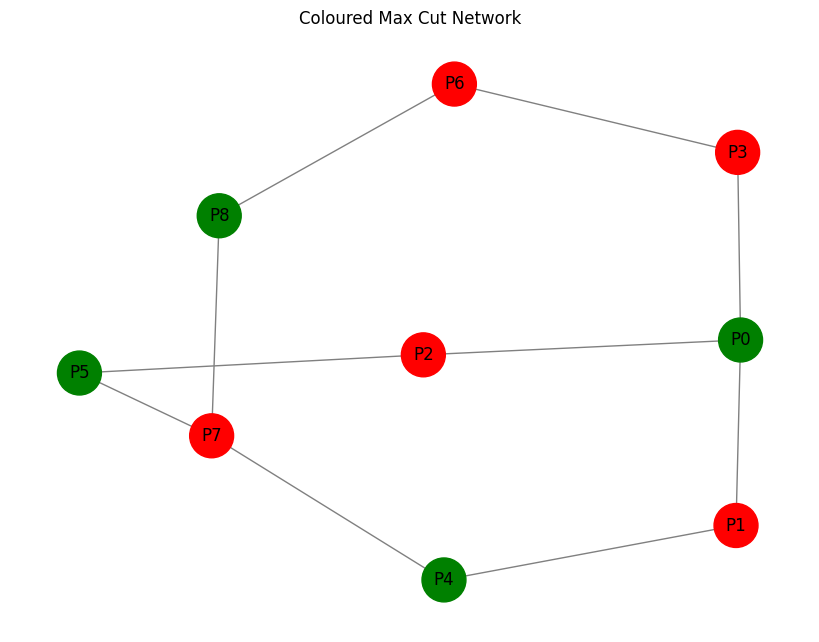

In [10]:
# colour the nodes based on the best result
# Draw the graph with new coloring
plt.figure(figsize=(8, 6))
nx.draw(max_cut_graph, pos, with_labels=True, node_color=colours, edge_color="gray", node_size=1000, font_size=12)
plt.title("Coloured Max Cut Network")
plt.show()

We can see that the graph is indeed divided into two subgroups in such a way that there are as many connections as possible between the two differently coloured subgroups. This is how the Max Cut problem can help us identify a set of people which will encourage a maximal exposure of the product through conversation and interactions of friends.